<div style="text-align: center; color:#FF9000">
    <h1><b>Assignment 5 - Convolutional Neural Network </b></h1>
    <h3>Artificial Intelligence - Spring 2024</h3></div>
<p style="text-align: center;text-decoration: underline">Alireza Hosseini</p>
<p style="text-align: center;text-decoration: underline">SID : 810100125</p>


# Setup environment

In [3]:
#%pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

In [50]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Config

## Model training config

In [51]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 32
EPOCHS = 10
TEST_TRAIN_RATIO = 0.75

SEQUENCE_LEN = 64

In [52]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


# Data Preparation

## Load Data

In [53]:
CSV_DATA = pd.read_csv("/home/alireza/University/AI/assignments/A5/twitter-suicidal-data.csv")
print(CSV_DATA.head)

<bound method NDFrame.head of                                                   tweet  intention
0     my life is meaningless i just want to end my l...          1
1     muttering i wanna die to myself daily for a fe...          1
2     work slave i really feel like my only purpose ...          1
3     i did something on the 2 of october i overdose...          1
4     i feel like no one cares i just want to die ma...          1
...                                                 ...        ...
9114  have you ever laid on your bed at night and cr...          1
9115  the fault the blame the pain s still there i m...          1
9116  stop asking me to trust you when i m still cou...          1
9117  i never know how to handle sadness crying make...          1
9118  when cancer takes a life we blame cancer depre...          1

[9119 rows x 2 columns]>


## Data Preprocessing

In [54]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alireza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alireza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alireza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alireza/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [55]:
def convert_emoji_to_text(text):
    """This function would replace emojies with a space"""
    return emoji.replace_emoji(text, replace=' ')

from urllib.parse import urlparse

def remove_urls_urllib(text, replacement_text=" "):
  """ This function removes URLs from a text string using urllib.parse (for simpler URLs) """
  words = [replacement_text if urlparse(word).scheme and urlparse(word).netloc else word for word in text.split()]
  return " ".join(words)

def remove_stopwords(tokens: list, stopwords):
  for i in range(len(tokens)) :
    if(tokens[i] in stopwords):
      tokens[i] = ''
  return tokens

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """

    #lowercase the text
    lowered_case = text.lower()

    # remove punctuation
    punctuation_removed = re.sub(r'[^\w\s]', '', lowered_case)

    # remove numbers
    numbers_removed = re.sub(r'\d', '', punctuation_removed)

    # remove urls
    urls_removed = remove_urls_urllib(numbers_removed)

    # remove usernames
    usernames_removed = re.sub('@[^\s]+','', urls_removed)

    # remove extra spaces
    extraSpaces_removed = re.sub(' +', ' ', usernames_removed)

    # convert emojis to text
    emojies_converted = convert_emoji_to_text(extraSpaces_removed)

    # remove non-word characters
    nonWords_removed = emojies_converted #TODO : What should we do here?

    # lemmatization and tokenization of the text
    tokenized = nltk.word_tokenize(nonWords_removed)
    lemmas = [lemmatizer.lemmatize(word) for word in tokenized]

    # remove stopwords
    stopwords_removed = remove_stopwords(lemmas, stopwords)

    # remove empty/white tokens
    finalized_tokens = list(filter(None, stopwords_removed))

    return finalized_tokens


### Why do we use Lower Case ?

- __*Advantages :*__
    - __Consistency :__ By converting all text to lowercase, We ensure that words like "Apple" and "apple" are treated as the same token 
    - __Reduced Vocabulary Size :__ Lowercasing reduces the number of unique tokens, which can be beneficial for __memory efficiency__ and model performance.  
    - __Generalization :__ Models trained on lowercased text can generalize better because they are not sensitive to case variations in the input text.
- __*Disadvantages :*__
    - __Loss of Information :__ Case can carry important information, especially for __proper nouns__ (e.g., "Amazon" vs. "amazon") and __acronyms__ (e.g., "NASA" vs. "nasa"). 
    - __Ambiguity and Confusion :__ Lowercasing can introduce ambiguity in distinguishing between different entities or meanings that are __case-sensitive__. For example, "US" (United States) vs. "us" (pronoun).

### Why do we remove digits from inputs ?

- __*Advantages :*__
    - Concentrate on Sentimental Words
    - Simpler Feature Space (Reduced Dimensionality)
    - Less Distracting Information (Noise Reduction)
- __*Disadvantages :*__
    - Sometimes, numbers can carry important __context__ or contribute to the sentiment. For example, "I waited for 2 hours" implies a negative sentiment, while "I won 1st place" implies a positive sentiment. ("The product lasted 2 days").
    - Removing numbers can sometimes lead to ambiguous or incomplete text

### Importance of Hashtags
- __Context and Meaning__ : Hashtags often encapsulate the main topic or theme of the tweet, providing valuable context. _example : "#Happy" clearly indicates a positive sentiment._
- __Sentiment Indicators :__ Many hashtags convey emotions directly _(e.g., #love, #hate, #excited)_, acting as strong sentiment indicators.
- __Topic Identification :‌__ Hashtags are used to categorize tweets around specific topics, events, or __trends__ _(e.g., #Oscars, #Election2024)_.
- __Clarification :__ Hashtags can disambiguate the meaning of a tweet that might be otherwise ambiguous. _For example, "I can't believe this! #AmazingExperience"_

In [42]:
import random

SAMPLES_AMOUNT = 5
random_tweets = (random.sample(range(0, len(CSV_DATA)), SAMPLES_AMOUNT))
print(f"{CSV_DATA['tweet'][random_tweets]} -> {CSV_DATA['tweet'][random_tweets].apply(lambda x : preprocess_data(x))}")

7389                                        i want to die
3057    why i dont care to be here 1 childhood trauma ...
3558    i m not liking that new itunes pricing at all ...
5847       my friend in infy got laid off m sorry for him
8129    i really want tr mp to just choke on something...
Name: tweet, dtype: object -> 7389                                          [want, die]
3057    [dont, care, childhood, trauma, strict, parent...
3558    [liking, new, itunes, pricing, mean, seen, sev...
5847                     [friend, infy, got, laid, sorry]
8129    [really, want, tr, mp, choke, something, small...
Name: tweet, dtype: object


# Word2Vec - Word Embedding

In [43]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [44]:
W2V_PATH = "/home/alireza/University/AI/assignments/A5/word2VecModel" # Path to W2V if downloaded
if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

Loading Word2Vec model...
Word2Vec model is loaded.


In [11]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size
print(EMBEDDING_VECTOR_DIM)

300


### Methods to deal with out-of-vocabulary (OOV) tokens

- Special Token (_UNK_) :
    - (+) Simple to implement
    - (-) Information loss, as different OOV tokens are treated identically.
- Random Initialization :
    - (+) Preserves the uniqueness of each token.
    - (-) Can introduce noise and instability in early training stages.
- Contextualized Embeddings (e.g., BERT) :
    - (+) Provides context-sensitive embeddings for all tokens, including OOV words.
    - (-) Requires significant computational resources.

# Dataset

In [45]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        self.dataframe['Initial Tokens Length'] = self.dataframe[self.df_token_col].apply(len)

        # Add padding
        #self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
        self.dataframe.loc[:, self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        #self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)
        self.dataframe["vector"]  = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.Tensor:
      tensor_list = []
      for i in range(len(tokens)) :
        if(i >= self.max_sequence_len):
            break
        if tokens[i] in self.w2v_model:
          tensor_list.append(torch.tensor(self.w2v_model[tokens[i]]))
        else :
          tensor_list.append(torch.zeros(self.vector_size))
      return torch.stack(tensor_list)

    def _pad(self, tokens: list):
        if(len(tokens) < self.max_sequence_len):
            return tokens + [0 for _ in range(self.max_sequence_len - len(tokens))]
        else :
            return tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

# Prepare Data

## Split Data into train-valid

In [46]:
CSV_DATA_TEST, CSV_DATA_TRAIN = train_test_split(CSV_DATA, test_size=TEST_TRAIN_RATIO)
print(len(CSV_DATA_TRAIN), len(CSV_DATA_TEST))

6840 2279


## Create Datasets

In [47]:
SEQUENCE_LEN = 64
pd.options.mode.copy_on_write = True
train_dataset = Twitter(CSV_DATA_TRAIN, w2v_model, SEQUENCE_LEN)
valid_dataset = Twitter(CSV_DATA_TEST, w2v_model, SEQUENCE_LEN)



print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

Deleted 0-Len Samples: 23
Deleted 0-Len Samples: 7
Train dataset length: 6817
Valid dataset length: 2272


In [48]:
train_dataset.dataframe

,tweet,intention,tokens,Initial Tokens Length,vector
0,sometimes i wonder where my money goes,0,"[sometimes, wonder, money, go, 0, 0, 0, 0, 0, ...",4,"[[tensor(0.0967), tensor(-0.0708), tensor(-0.0..."
1,an oracle swallowed a sun and spit out 10000,0,"[oracle, swallowed, sun, spit, 0, 0, 0, 0, 0, ...",4,"[[tensor(0.4277), tensor(0.0225), tensor(-0.11..."
2,watching bowling for columbine and realised to...,0,"[watching, bowling, columbine, realised, tomor...",11,"[[tensor(0.2197), tensor(0.1484), tensor(0.265..."
3,its over ive decided ive given up thank you re...,1,"[ive, decided, ive, given, thank, reddit, happ...",13,"[[tensor(-0.4121), tensor(0.1885), tensor(-0.2..."
4,rant i want to die ive wanted to die for years...,1,"[rant, want, die, ive, wanted, die, year, noth...",42,"[[tensor(0.0645), tensor(-0.0010), tensor(0.00..."
...,...,...,...,...,...
6812,injury took my friends wife nothing to live fo...,1,"[injury, took, friend, wife, nothing, live, wi...",192,"[[tensor(0.2002), tensor(0.0991), tensor(-0.11..."
6813,i hate levi i hate him so much when i see him ...,0,"[hate, levi, hate, much, see, want, die, feel,...",27,"[[tensor(0.1328), tensor(0.0801), tensor(0.287..."
6814,girlfriend just left me i have no friends pare...,1,"[girlfriend, left, friend, parent, dont, care,...",10,"[[tensor(-0.0239), tensor(-0.3516), tensor(-0...."
6815,rented marley and me if you watch it be prepar...,0,"[rented, marley, watch, prepared, cry, expecti...",7,"[[tensor(0.2676), tensor(-0.2031), tensor(-0.1..."


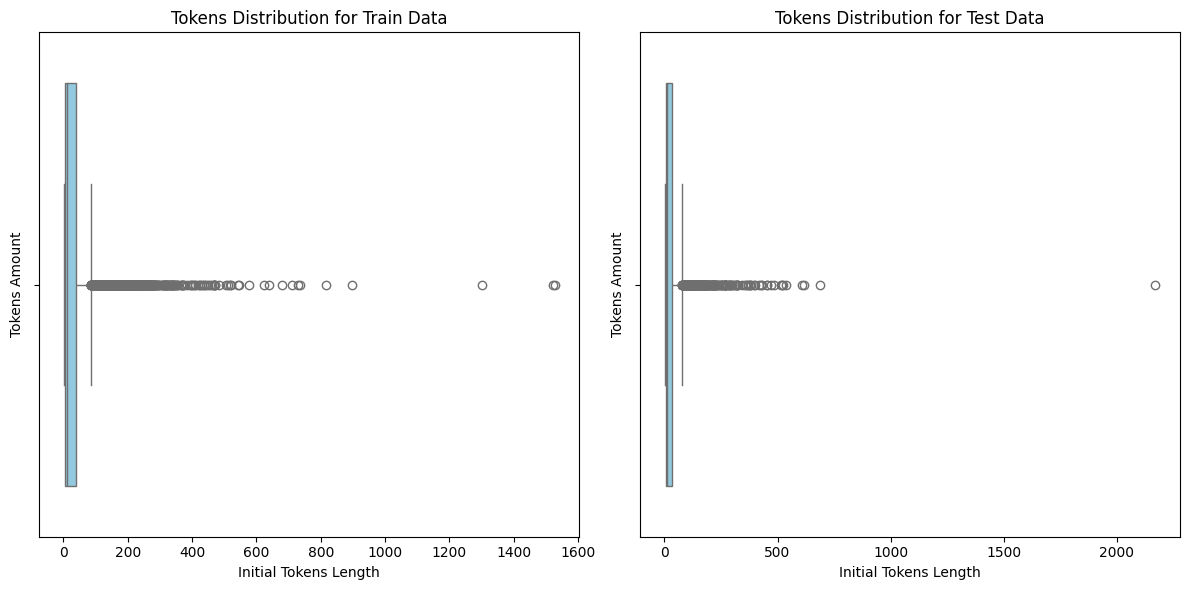

In [49]:
# Plot using Matplotlib
plt.figure(figsize=(12, 6))

# Subplot for Matplotlib
plt.subplot(1, 2, 1)
sns.boxplot(data=train_dataset.dataframe['Initial Tokens Length'], orient='h', color='skyblue')
plt.title('Tokens Distribution for Train Data')
plt.ylabel('Tokens Amount')

# Subplot for Seaborn
plt.subplot(1, 2, 2)
sns.boxplot(data=valid_dataset.dataframe['Initial Tokens Length'], orient='h', color='skyblue')
plt.title('Tokens Distribution for Test Data')
plt.ylabel('Tokens Amount')


# Show the plot
plt.tight_layout()
plt.show()

# Model and Train

## Utils

In [18]:
from typing import Literal

@torch.no_grad()
def model_eval(model, loader, loss_function, device: str = 'auto'):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    correct = 0
    total = 0

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    model = model.to(device)
    model.eval()

    itr = tqdm(loader, total=len(loader), leave=True)

    for inputs, labels in itr:
        # Move inputs and labels to the specified device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass to get outputs
        outputs = model(inputs)
        
        # Calculate loss
        loss = loss_function(outputs, labels)
        
        # Update the total loss
        test_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Update progress bar with current loss and accuracy
        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(correct / total, 5),
        )

    # Calculate average loss and accuracy
    test_loss /= len(loader)
    test_acc = correct / total

    return test_loss, test_acc


In [19]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: str = 'auto',
):

    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    model.to(device)

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    # Create dataloaders from datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        itr = tqdm(train_loader, total=len(train_loader), leave=True)
        
        for inputs, labels in itr:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Clear optimizer's state and zero previous gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model(inputs)
            
            # Calculate loss
            loss = loss_function(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update epoch's loss
            epoch_loss += loss.item()

            # Calculate and update accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            epoch_acc = correct / total

            # Update progress bar with current loss and accuracy
            itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")

        train_losses.append(epoch_loss / len(train_loader) *100)
        train_accs.append(epoch_acc *100)

        # Evaluate on validation set
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
        )
        
        valid_losses.append(valid_loss*100)
        valid_accs.append(valid_acc*100)

        # Print epoch summary
        print(f"Epoch {epoch + 1}/{epochs}:")
        print(f"Train Loss: {train_losses[-1]:.2f}%, Train Acc: {train_accs[-1]:.2f}%")
        print(f"Valid Loss: {valid_losses[-1]:.2f}%, Valid Acc: {valid_accs[-1]:.2f}% \n")

    history = {
        "train_loss": train_losses,
        "train_acc": train_accs,
        "valid_loss": valid_losses,
        "valid_acc": valid_accs,
    }
    return history

In [20]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()

In [21]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    labels = []
    for inputs, true_labels in itr:
        labels.extend(true_labels.tolist())

    predicted = []
    for inputs, _ in itr:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predicted.extend(preds.tolist())

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

In [22]:
class CNN(nn.Module):
    def __init__(self, input_size, num_classes): 
        super(CNN, self).__init__()

        # Layer 1
        self.L1_conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.L1_conv2 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=5, padding=2)
        self.L1_conv3 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=7, padding=3)
        # Layer 2
        self.L2_conv1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.L2_conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.L2_conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3)
        
        # Max Pooling
        self.max_pool = nn.MaxPool1d(kernel_size=64)
        
        # Layer 3
        self.flatten = nn.Flatten()
        
        # Layer 5-6 (Fully connected layers) 
        self.FC1 = nn.Linear(in_features=3 * 128, out_features=128)
        self.FC2 = nn.Linear(in_features=128, out_features=num_classes)
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.permute(0, 2, 1)

        # Layer 1
        x1 = self.relu(self.L1_conv1(x))
        x2 = self.relu(self.L1_conv2(x))
        x3 = self.relu(self.L1_conv3(x))
        
        # Layer 2
        x1 = self.relu(self.L2_conv1(x1))
        x2 = self.relu(self.L2_conv2(x2))
        x3 = self.relu(self.L2_conv3(x3))

        # Layer 3
        x1 = self.max_pool(x1)
        x2 = self.max_pool(x2)
        x3 = self.max_pool(x3)
        
        # Concatenate the outputs of the second layer
        x = torch.cat([x1, x2, x3], dim=1)
        # Flatten
        x = self.flatten(x)

        # Fully connected layers
        x = self.relu(self.FC1(x))
        x = self.FC2(x)
        
        return x


## Training

In [23]:
cnn_model = CNN(input_size=300, num_classes=2).to(DEVICE)

### Adam  Optimizer

- __*How Adam Optimizer Works :*__
    1. __Initialization :__ Adam maintains two moving averages for each parameter: the first moment (mean) and the second moment (uncentered variance). These are initialized to zero.
    2. __Parameter Updates :__
        - Compute Gradients: Calculate the gradient of the loss function with respect to the parameters.
        - Update Moving Averages :
            - First Moment (m): Update the moving average of the gradients (mean).
            $$m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t$$
            - Second Moment (v): Update the moving average of the squared gradients (variance).
            $$v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2$$
        - Bias Correction: Correct the bias in the estimates of the first and second moments.
        $$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
        - Parameter Update: Update the parameters using the corrected moments.
        $$\theta_t = \theta_{t-1} - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$


- **Adam**:
  - **Advantages**:
    - Adapts the learning rate based on the data, often leading to __faster convergence__.
    - Requires less tuning of the learning rate.
    - Effective for problems with __noisy__ or sparse gradients.
  - **Disadvantages**:
    - More computationally __expensive__ per iteration compared to plain SGD.
    - May sometimes result in __suboptimal generalization__ compared to simpler methods like SGD.

- **SGD**:
  - **Advantages**:
    - __Simpler__ to implement and computationally efficient.
    - Often leads to better generalization on some problems, especially when used with momentum.
  - **Disadvantages**:
    - Requires careful __tuning__ of the learning rate and possibly a learning rate schedule.
    - May __converge slowly__ if the learning rate is not well-tuned.







### Cross Entropy 

Cross-entropy loss function, also known as __log loss__, is commonly used in classification tasks, especially when dealing with multiple classes. It measures the difference between two probability distributions: the predicted probability distribution and the actual (true) probability distribution of the labels.
$$\text{CrossEntropy}(y, \hat{y}) = -\sum_{i} y_i \cdot \log(\hat{y}_i)$$

__Focuses on Correct Classifications :__ The loss is higher when the model makes wrong predictions, especially for highly confident (close to 1 or 0) incorrect classifications. This steers the model towards learning to assign higher probabilities to the correct sentiment.

In [24]:
cnn_model_train_history = train_model(
    model= cnn_model,
    batch_size = BATCH_SIZE,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    epochs = EPOCHS,
    train_set = train_dataset,
    valid_set = valid_dataset,
    device = DEVICE
)

(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 48.34it/s, accuracy=0.896, loss=0.236]


Epoch 1/10:
Train Loss: 39.50%, Train Acc: 81.93%
Valid Loss: 28.56%, Valid Acc: 89.57% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 49.72it/s, accuracy=0.884, loss=0.274]


Epoch 2/10:
Train Loss: 25.60%, Train Acc: 89.85%
Valid Loss: 29.51%, Valid Acc: 88.38% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 49.66it/s, accuracy=0.871, loss=0.312]


Epoch 3/10:
Train Loss: 24.22%, Train Acc: 90.52%
Valid Loss: 30.27%, Valid Acc: 87.10% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.09it/s, accuracy=0.902, loss=0.209]


Epoch 4/10:
Train Loss: 23.81%, Train Acc: 90.24%
Valid Loss: 24.77%, Valid Acc: 90.18% 



(Eval): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 45.59it/s, accuracy=0.899, loss=0.21]


Epoch 5/10:
Train Loss: 19.75%, Train Acc: 92.03%
Valid Loss: 24.57%, Valid Acc: 89.88% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 52.10it/s, accuracy=0.904, loss=0.216]


Epoch 6/10:
Train Loss: 18.65%, Train Acc: 92.52%
Valid Loss: 23.72%, Valid Acc: 90.36% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 50.80it/s, accuracy=0.894, loss=0.258]


Epoch 7/10:
Train Loss: 16.78%, Train Acc: 93.30%
Valid Loss: 24.85%, Valid Acc: 89.44% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 29.33it/s, accuracy=0.899, loss=0.215]


Epoch 8/10:
Train Loss: 15.79%, Train Acc: 94.01%
Valid Loss: 24.18%, Valid Acc: 89.92% 



(Eval): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 56.92it/s, accuracy=0.901, loss=0.22]


Epoch 9/10:
Train Loss: 13.78%, Train Acc: 94.92%
Valid Loss: 23.91%, Valid Acc: 90.05% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 49.64it/s, accuracy=0.899, loss=0.278]

Epoch 10/10:
Train Loss: 13.31%, Train Acc: 94.81%
Valid Loss: 26.38%, Valid Acc: 89.88% 



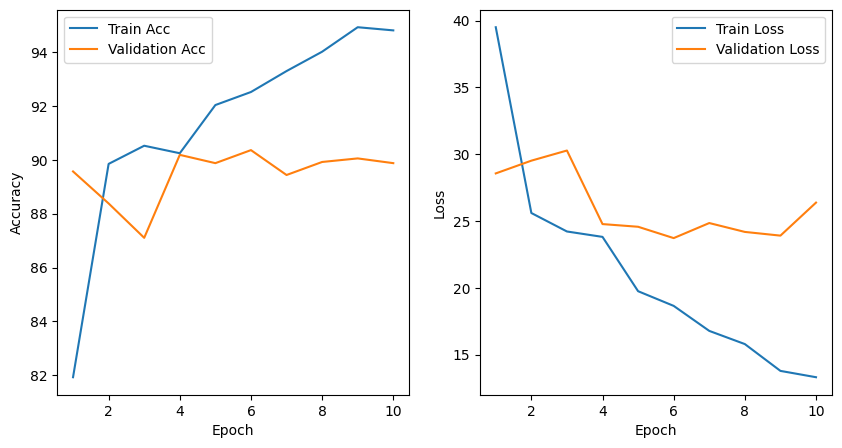

In [25]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)

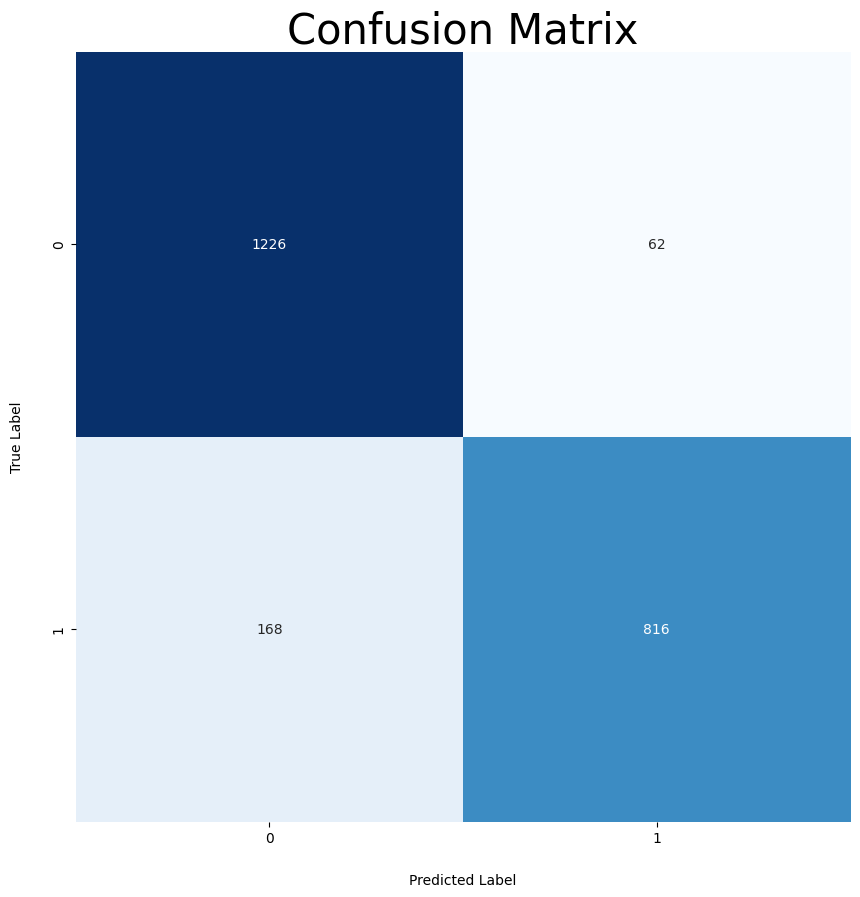

In [26]:
cnn_model_report = generate_confusion_matrix(
    model=cnn_model,
    dataset=valid_dataset
)

In [27]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.891
F1:        0.895
Precision: 0.904
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1288
           1       0.93      0.83      0.88       984

    accuracy                           0.90      2272
   macro avg       0.90      0.89      0.90      2272
weighted avg       0.90      0.90      0.90      2272



## Biger Batch Size?

In [28]:
BATCH_SIZE = 64
LEARNING_RATE = 2e-2

cnn_model_bigger_batch = CNN(input_size=300, num_classes=2).to(DEVICE)

cnn_model_train_history_bigger_batch = train_model(
    model= cnn_model_bigger_batch,
    batch_size = BATCH_SIZE,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = torch.optim.Adam(cnn_model_bigger_batch.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    epochs = EPOCHS,
    train_set = train_dataset,
    valid_set = valid_dataset,
    device = DEVICE
)

(Eval): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.65it/s, accuracy=0.86, loss=0.294]


Epoch 1/10:
Train Loss: 41.75%, Train Acc: 81.63%
Valid Loss: 35.11%, Valid Acc: 86.00% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 28.27it/s, accuracy=0.861, loss=0.316]


Epoch 2/10:
Train Loss: 32.69%, Train Acc: 86.77%
Valid Loss: 33.82%, Valid Acc: 86.14% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 28.28it/s, accuracy=0.847, loss=0.245]


Epoch 3/10:
Train Loss: 32.57%, Train Acc: 86.81%
Valid Loss: 37.02%, Valid Acc: 84.73% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 12.14it/s, accuracy=0.868, loss=0.286]


Epoch 4/10:
Train Loss: 36.19%, Train Acc: 85.51%
Valid Loss: 33.82%, Valid Acc: 86.80% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 30.36it/s, accuracy=0.868, loss=0.364]


Epoch 5/10:
Train Loss: 32.87%, Train Acc: 86.31%
Valid Loss: 32.41%, Valid Acc: 86.84% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 27.23it/s, accuracy=0.884, loss=0.231]


Epoch 6/10:
Train Loss: 32.22%, Train Acc: 87.00%
Valid Loss: 30.31%, Valid Acc: 88.42% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 31.64it/s, accuracy=0.773, loss=0.448]


Epoch 7/10:
Train Loss: 32.15%, Train Acc: 86.74%
Valid Loss: 49.21%, Valid Acc: 77.33% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 27.76it/s, accuracy=0.871, loss=0.281]


Epoch 8/10:
Train Loss: 31.99%, Train Acc: 87.36%
Valid Loss: 32.33%, Valid Acc: 87.10% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 28.74it/s, accuracy=0.868, loss=0.221]


Epoch 9/10:
Train Loss: 29.86%, Train Acc: 87.62%
Valid Loss: 31.03%, Valid Acc: 86.84% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 16.54it/s, accuracy=0.884, loss=0.253]

Epoch 10/10:
Train Loss: 28.70%, Train Acc: 88.19%
Valid Loss: 28.04%, Valid Acc: 88.42% 



Recall:    0.881
F1:        0.882
Precision: 0.883
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1288
           1       0.87      0.86      0.87       984

    accuracy                           0.88      2272
   macro avg       0.88      0.88      0.88      2272
weighted avg       0.88      0.88      0.88      2272



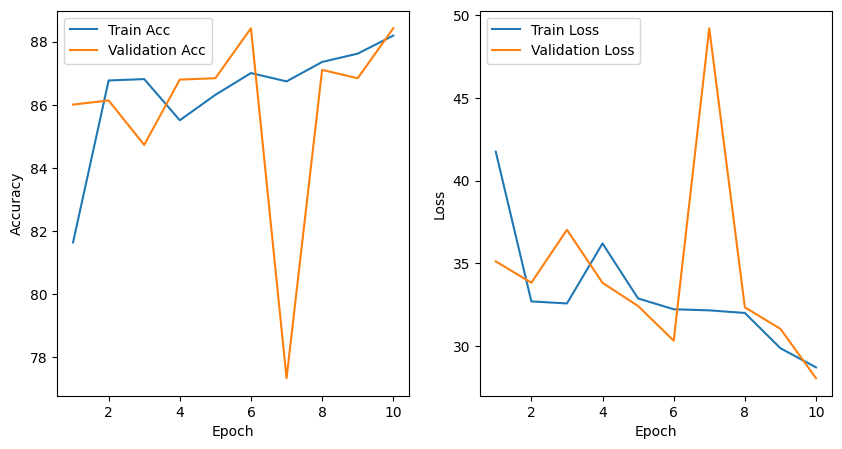

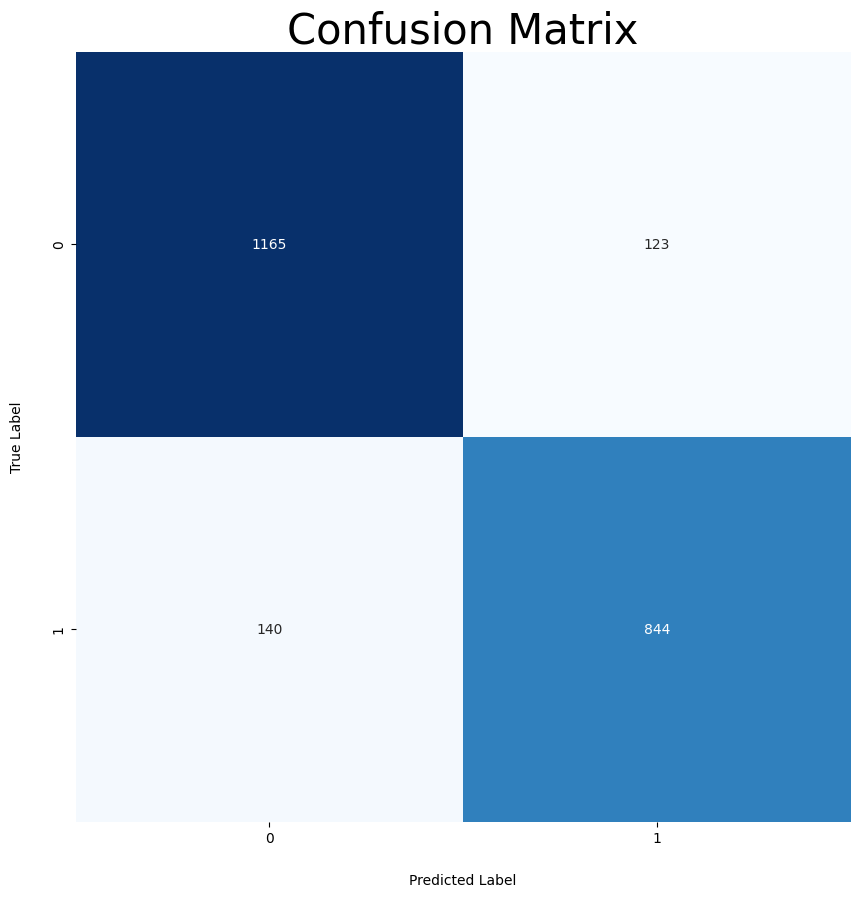

In [29]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", cnn_model_train_history_bigger_batch["train_acc"]),
            ("Validation Acc", cnn_model_train_history_bigger_batch["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", cnn_model_train_history_bigger_batch["train_loss"]),
            ("Validation Loss", cnn_model_train_history_bigger_batch["valid_loss"])
        ]
    }
)

cnn_model_report_bigger_batch = generate_confusion_matrix(
    model=cnn_model_bigger_batch,
    dataset=valid_dataset
)

print(f"Recall:    {cnn_model_report_bigger_batch['recall']:.3f}")
print(f"F1:        {cnn_model_report_bigger_batch['f1']:.3f}")
print(f"Precision: {cnn_model_report_bigger_batch['precision']:.3f}")
print(cnn_model_report_bigger_batch['report'])

## Effect of Context Window Size

- __*Advantages :*__
    - Capture More Sentiment-Bearing Information
    - Improve Context Understanding
- __*Disadvantages :*__
    - Increased Computational Cost
    - Risk of Capturing Irrelevant Information
    - Too much information can make it harder for the model to identify the most relevant parts

In [30]:
SEQUENCE_LEN = 192

train_dataset_bigger_context = Twitter(CSV_DATA_TRAIN, w2v_model, SEQUENCE_LEN)
valid_dataset_bigger_context = Twitter(CSV_DATA_TEST, w2v_model, SEQUENCE_LEN)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Valid dataset length: {len(valid_dataset)}")

Deleted 0-Len Samples: 23
Deleted 0-Len Samples: 7
Train dataset length: 6817
Valid dataset length: 2272


In [31]:
BATCH_SIZE = 32
LEARNING_RATE = 4e-4

cnn_model_bigger_context = CNN(input_size=300, num_classes=2).to(DEVICE)

cnn_model_train_history_bigger_context = train_model(
    model= cnn_model_bigger_context,
    batch_size = BATCH_SIZE,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = torch.optim.Adam(cnn_model_bigger_context.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    epochs = EPOCHS,
    train_set = train_dataset,
    valid_set = valid_dataset,
    device = DEVICE
)

(Eval): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 49.60it/s, accuracy=0.87, loss=0.283]


Epoch 1/10:
Train Loss: 39.85%, Train Acc: 83.83%
Valid Loss: 32.68%, Valid Acc: 87.02% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 43.15it/s, accuracy=0.893, loss=0.246]


Epoch 2/10:
Train Loss: 27.33%, Train Acc: 89.09%
Valid Loss: 28.22%, Valid Acc: 89.35% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 46.46it/s, accuracy=0.888, loss=0.288]


Epoch 3/10:
Train Loss: 23.88%, Train Acc: 90.42%
Valid Loss: 27.86%, Valid Acc: 88.82% 



(Eval): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 26.14it/s, accuracy=0.9, loss=0.259]


Epoch 4/10:
Train Loss: 22.37%, Train Acc: 91.05%
Valid Loss: 25.36%, Valid Acc: 90.01% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 30.39it/s, accuracy=0.894, loss=0.233]


Epoch 5/10:
Train Loss: 19.54%, Train Acc: 92.28%
Valid Loss: 26.65%, Valid Acc: 89.39% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 30.25it/s, accuracy=0.901, loss=0.228]


Epoch 6/10:
Train Loss: 18.92%, Train Acc: 92.64%
Valid Loss: 25.71%, Valid Acc: 90.14% 



(Eval): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.45it/s, accuracy=0.895, loss=0.24]


Epoch 7/10:
Train Loss: 15.59%, Train Acc: 93.97%
Valid Loss: 25.09%, Valid Acc: 89.52% 



(Eval): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 48.05it/s, accuracy=0.895, loss=0.21]


Epoch 8/10:
Train Loss: 14.46%, Train Acc: 94.84%
Valid Loss: 25.73%, Valid Acc: 89.52% 



(Eval): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 44.20it/s, accuracy=0.899, loss=0.22]


Epoch 9/10:
Train Loss: 12.51%, Train Acc: 95.60%
Valid Loss: 25.68%, Valid Acc: 89.88% 



(Eval): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.88it/s, accuracy=0.9, loss=0.213]

Epoch 10/10:
Train Loss: 10.98%, Train Acc: 96.39%
Valid Loss: 26.02%, Valid Acc: 90.01% 



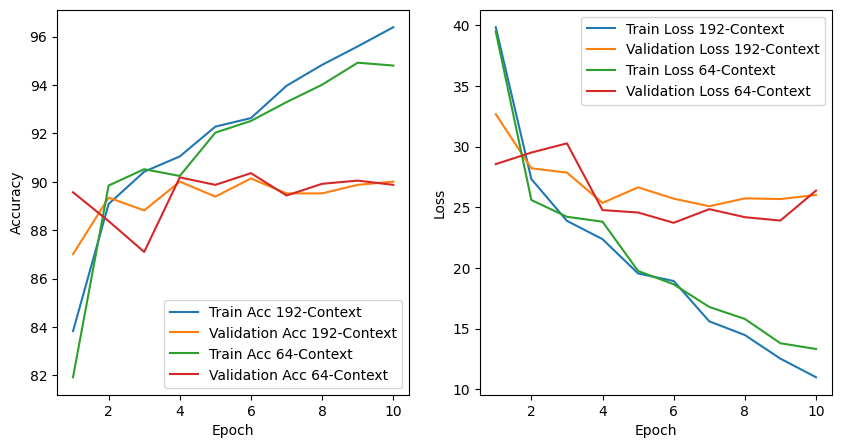

In [32]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc 192-Context", cnn_model_train_history_bigger_context["train_acc"]),
            ("Validation Acc 192-Context", cnn_model_train_history_bigger_context["valid_acc"]),
            ("Train Acc 64-Context", cnn_model_train_history["train_acc"]),
            ("Validation Acc 64-Context", cnn_model_train_history["valid_acc"])
        ],
        "Loss - Epoch": [
            ("Train Loss 192-Context", cnn_model_train_history_bigger_context["train_loss"]),
            ("Validation Loss 192-Context", cnn_model_train_history_bigger_context["valid_loss"]),
            ("Train Loss 64-Context", cnn_model_train_history["train_loss"]),
            ("Validation Loss 64-Context", cnn_model_train_history["valid_loss"])
        ]
    }
)

## Regularization Methods

In [38]:
class CNN_Regular(nn.Module):
    def __init__(self, input_size, num_classes): 
        super(CNN_Regular, self).__init__()

        # Layer 1
        self.L1_conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.L1_bn1 = nn.BatchNorm1d(64)
        self.L1_conv2 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=5, padding=2)
        self.L1_bn2 = nn.BatchNorm1d(64)
        self.L1_conv3 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=7, padding=3)
        self.L1_bn3 = nn.BatchNorm1d(64)

        # Layer 2
        self.L2_conv1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.L2_bn1 = nn.BatchNorm1d(128)
        self.L2_conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.L2_bn2 = nn.BatchNorm1d(128)
        self.L2_conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=7, padding=3)
        self.L2_bn3 = nn.BatchNorm1d(128)
        
        # Max Pooling
        self.max_pool = nn.MaxPool1d(kernel_size=64)
        
        # Dropout
        self.dropout = nn.Dropout(0.4)

        # Layer 3
        self.flatten = nn.Flatten()
        
        # Layer 5-6 (Fully connected layers) 
        self.FC1 = nn.Linear(in_features=3 * 128, out_features=128)
        self.FC2 = nn.Linear(in_features=128, out_features=num_classes)
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.permute(0, 2, 1)

        # Layer 1
        x1 = self.relu(self.L1_bn1(self.L1_conv1(x)))
        x2 = self.relu(self.L1_bn2(self.L1_conv2(x)))
        x3 = self.relu(self.L1_bn3(self.L1_conv3(x)))
        
        # Layer 2
        x1 = self.relu(self.L2_bn1(self.L2_conv1(x1)))
        x2 = self.relu(self.L2_bn2(self.L2_conv2(x2)))
        x3 = self.relu(self.L2_bn3(self.L2_conv3(x3)))

        # Layer 3
        x1 = self.max_pool(x1)
        x2 = self.max_pool(x2)
        x3 = self.max_pool(x3)
        
        # Concatenate the outputs of the second layer
        x = torch.cat([x1, x2, x3], dim=1)

        # Flatten
        x = self.flatten(x)

        # Apply Dropout
        x = self.dropout(x)

        # Fully connected layers
        x = self.relu(self.FC1(x))
        x = self.FC2(x)
        
        return x


In [39]:

cnn_model_regular = CNN_Regular(input_size=300, num_classes=2).to(DEVICE)

cnn_model_train_history_regular = train_model(
    model= cnn_model_regular,
    batch_size = BATCH_SIZE,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = torch.optim.Adam(cnn_model_regular.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    epochs = EPOCHS,
    train_set = train_dataset,
    valid_set = valid_dataset,
    device = DEVICE
)

  0%|                                                                                                                                                      | 0/214 [00:00<?, ?it/s]

(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 51.40it/s, accuracy=0.832, loss=0.396]


Epoch 1/10:
Train Loss: 32.97%, Train Acc: 85.76%
Valid Loss: 42.20%, Valid Acc: 83.19% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 52.42it/s, accuracy=0.915, loss=0.212]


Epoch 2/10:
Train Loss: 20.08%, Train Acc: 91.40%
Valid Loss: 23.53%, Valid Acc: 91.55% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 49.28it/s, accuracy=0.909, loss=0.192]


Epoch 3/10:
Train Loss: 15.02%, Train Acc: 94.09%
Valid Loss: 23.10%, Valid Acc: 90.89% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.04it/s, accuracy=0.912, loss=0.138]


Epoch 4/10:
Train Loss: 14.95%, Train Acc: 93.65%
Valid Loss: 23.55%, Valid Acc: 91.24% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 27.22it/s, accuracy=0.878, loss=0.315]


Epoch 5/10:
Train Loss: 9.95%, Train Acc: 95.97%
Valid Loss: 31.25%, Valid Acc: 87.76% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 30.43it/s, accuracy=0.905, loss=0.119]


Epoch 6/10:
Train Loss: 9.03%, Train Acc: 96.55%
Valid Loss: 25.77%, Valid Acc: 90.54% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 49.80it/s, accuracy=0.905, loss=0.216]


Epoch 7/10:
Train Loss: 7.27%, Train Acc: 97.32%
Valid Loss: 31.06%, Valid Acc: 90.49% 



(Eval): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 45.71it/s, accuracy=0.89, loss=0.348]


Epoch 8/10:
Train Loss: 7.52%, Train Acc: 97.30%
Valid Loss: 32.33%, Valid Acc: 89.04% 



(Eval): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 45.50it/s, accuracy=0.905, loss=0.263]


Epoch 9/10:
Train Loss: 6.29%, Train Acc: 97.61%
Valid Loss: 31.48%, Valid Acc: 90.54% 



(Eval): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 22.20it/s, accuracy=0.856, loss=0.28]

Epoch 10/10:
Train Loss: 6.27%, Train Acc: 97.93%
Valid Loss: 50.21%, Valid Acc: 85.56% 



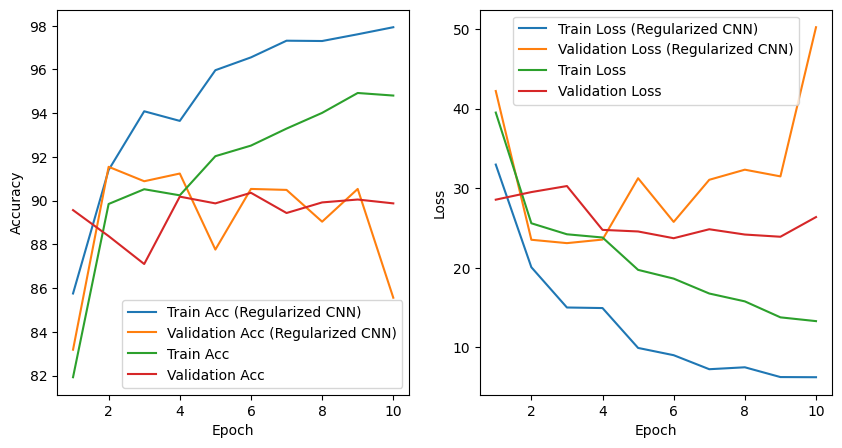

In [40]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc (Regularized CNN)", cnn_model_train_history_regular["train_acc"]),
            ("Validation Acc (Regularized CNN)", cnn_model_train_history_regular["valid_acc"]),
            ("Train Acc", cnn_model_train_history["train_acc"]),
            ("Validation Acc", cnn_model_train_history["valid_acc"])
        ],
        "Loss - Epoch": [
            ("Train Loss (Regularized CNN)", cnn_model_train_history_regular["train_loss"]),
            ("Validation Loss (Regularized CNN)", cnn_model_train_history_regular["valid_loss"]),
            ("Train Loss", cnn_model_train_history["train_loss"]),
            ("Validation Loss", cnn_model_train_history["valid_loss"])
        ]
    }
)